# DSCI 573: Feature and model selection 

## Lecture 5: Ensembles

UBC Master of Data Science program, 2020-21

Instructor: Varada Kolhatkar 

<blockquote>
The interests of truth require a diversity of opinions.    
    
by John Stuart Mill
</blockquote>



In [1]:
import os

%matplotlib inline
import string
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# data
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer

# Feature selection
from sklearn.feature_selection import RFE, RFECV
from sklearn.impute import SimpleImputer

# classifiers / models
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV

# other
from sklearn.metrics import accuracy_score, log_loss, make_scorer, mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    ShuffleSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler,
)
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier

In [2]:
# copied from 571 lecture 1
import re

import graphviz
from sklearn.tree import export_graphviz


def display_tree(feature_names, tree):
    """ For binary classification only """
    dot = export_graphviz(
        tree,
        out_file=None,
        feature_names=feature_names,
        class_names=tree.classes_.astype(str),
        impurity=False,
        precision=4,
    )
    # adapted from https://stackoverflow.com/questions/44821349/python-graphviz-remove-legend-on-nodes-of-decisiontreeclassifier
    dot = re.sub(
        "(\\\\nsamples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])(\\\\nclass = [A-Za-z0-9]+)",
        "",
        dot,
    )
    dot = re.sub("(samples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])\\\\n", "", dot)
    return graphviz.Source(dot)

## Lecture learning objectives

From this lecture, you will be able to 

- Use `scikit-learn`'s `RandomForestClassifier` and explain its main hyperparameters. 
- Explain randomness in random forest algorithm. 
- Use other tree-based models such as as `XGBoost` and `LGBM`.  
- Employ ensemble classifier approaches, in particular model averaging and stacking.
- Explain voting and stacking and the differences between them.
- Use `scikit-learn` implementations of these ensemble methods.

## 1. Motivation

### The Netflix prize

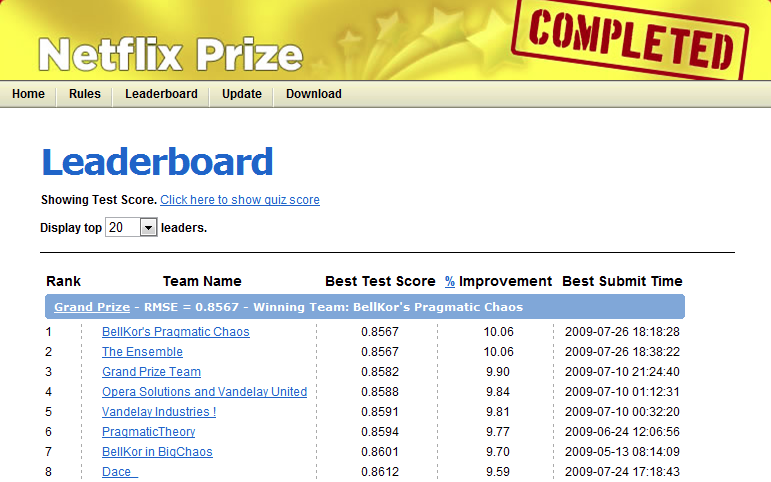

[Source](https://netflixtechblog.com/netflix-recommendations-beyond-the-5-stars-part-1-55838468f429)

- Most of the winning solutions for Kaggle competitions involve some kind of ensembling. For example: 

<img src="imgs/fraud_detection_kaggle.png" width="800" height="800">

So far we have the following models in our toolbox:

- Decision trees
- $k$-nearest neighbours
- SVM RBF
- Naive Bayes
- Logistic regression 

- Idea: Groups can often make better decisions than individuals, especially when group members are diverse enough. 

[The Wisdom of Crowds](http://wisdomofcrowds.blogspot.com/2009/12/introduction-part-i.html)

<img src="imgs/wisdom_of_crowds.jpg" width="400" height="400">

### Popularity of treed-based models

- Decision trees models are 
    - Interpretable 
    - The can capture non-linear relationships
    - They don't require scaling of the data and theoretically can work with categorical features. 
- But with a single decision trees are likely to overfit. 
- Idea: Combine multiple trees to build stronger models.
    - These kinds of models are extremely popular in industry. 

### Data

- Let's work with [the adult census data set](https://www.kaggle.com/uciml/adult-census-income) we used in 571. 

In [3]:
adult_df_large = pd.read_csv("data/adult.csv")
train_df, test_df = train_test_split(adult_df_large, test_size=0.2, random_state=42)
train_df_nan = train_df.replace("?", np.NaN)
test_df_nan = test_df.replace("?", np.NaN)
train_df_nan.head()

age  workclass  fnlwgt     education  education.num  \
5514    26    Private  256263       HS-grad              9   
19777   24    Private  170277       HS-grad              9   
10781   36    Private   75826     Bachelors             13   
32240   22  State-gov   24395  Some-college             10   
9876    31  Local-gov  356689     Bachelors             13   

           marital.status      occupation   relationship   race     sex  \
5514        Never-married    Craft-repair  Not-in-family  White    Male   
19777       Never-married   Other-service  Not-in-family  White  Female   
10781            Divorced    Adm-clerical      Unmarried  White  Female   
32240  Married-civ-spouse    Adm-clerical           Wife  White  Female   
9876   Married-civ-spouse  Prof-specialty        Husband  White    Male   

       capital.gain  capital.loss  hours.per.week native.country income  
5514              0             0              25  United-States  <=50K  
19777             0             0              35  United-States  <=50K  
10781             0             0              40  United-States  <=50K  
32240             0             0              20  United-States  <=50K  
9876              0             0              40  United-States  <=50K

In [4]:
numeric_features = ["age", "fnlwgt", "capital.gain", "capital.loss", "hours.per.week"]
categorical_features = [
    "workclass",
    "marital.status",
    "occupation",
    "relationship",
    "native.country",
]
ordinal_features = ["education"]
binary_features = ["sex"]
drop_features = ["race", "education.num"]
target_column = "income"

In [5]:
education_levels = [
    "Preschool",
    "1st-4th",
    "5th-6th",
    "7th-8th",
    "9th",
    "10th",
    "11th",
    "12th",
    "HS-grad",
    "Prof-school",
    "Assoc-voc",
    "Assoc-acdm",
    "Some-college",
    "Bachelors",
    "Masters",
    "Doctorate",
]

In [6]:
assert set(education_levels) == set(train_df["education"].unique())

In [7]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
tree_numeric_transformer = make_pipeline(SimpleImputer(strategy="median"))

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore"),
)

ordinal_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder(categories=[education_levels], dtype=int),
)

binary_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(drop="if_binary", dtype=int),
)

preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
)

In [8]:
X_train = train_df_nan.drop(columns=[target_column])
y_train = train_df_nan[target_column]

X_test = test_df_nan.drop(columns=[target_column])
y_test = test_df_nan[target_column]

### Do we have class imbalance? 

- There is class imbalance. But without any context, both classes seem equally important. 
- Let's use accuracy as our metric. 

In [9]:
train_df_nan["income"].value_counts(normalize=True)

<=50K    0.757985
>50K     0.242015
Name: income, dtype: float64

In [10]:
scoring_metric = "accuracy"

Let's store all the results in a dictionary called `results`. 

In [11]:
results = {}

In [13]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

### Baselines

### `DummyClassifier` baseline

In [14]:
dummy = DummyClassifier(strategy="stratified")
results["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

### `DecisionTreeClassifier` baseline

- Let's try decision tree classifier on our data. 

In [15]:
pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=123))
results["Decision tree"] = mean_std_cross_val_scores(
    pipe_dt, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

Dummy      Decision tree
fit_time     0.007 (+/- 0.001)  0.461 (+/- 0.015)
score_time   0.005 (+/- 0.000)  0.020 (+/- 0.000)
test_score   0.633 (+/- 0.008)  0.813 (+/- 0.003)
train_score  0.636 (+/- 0.004)  1.000 (+/- 0.000)

Decision tree is terribly overfitting. 

## 2. Random forests 

- Video 2

### `RandomForestClassifier` 

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=123))
results["Random forests"] = mean_std_cross_val_scores(
    pipe_rf, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

Dummy      Decision tree     Random forests
fit_time     0.007 (+/- 0.001)  0.463 (+/- 0.011)  6.891 (+/- 0.075)
score_time   0.005 (+/- 0.000)  0.020 (+/- 0.000)  0.096 (+/- 0.002)
test_score   0.634 (+/- 0.008)  0.813 (+/- 0.003)  0.857 (+/- 0.004)
train_score  0.631 (+/- 0.002)  1.000 (+/- 0.000)  1.000 (+/- 0.000)

The validation scores are better although it seems likes we are still overfitting. 

### What is a random forest? 

- A popular, off-the-shelf tree-based model. 

- General idea
    - `fit` a diverse set of decision trees by **injecting randomness** in the classifier construction
    - `predict` by taking the average of predictions given by individual classifiers

### Random forests

- How do we inject randomness in the classifier construction? 
    1. Data: **Build each tree on a bootstrap sample** (i.e., a sample drawn **with replacement** from the training set)
    2. Features: Consider a **random subset of features at each split**. 

Note: There is also something called `ExtraTreesClassifier`, where we add more randomness by consider a random subset of features at each split and **random threshold**. 

### The random forests classifier 

- Create a collection (ensemble) of trees. Grow each tree on an independent bootstrap sample from the data.
- At each node:
    - Randomly select a subset of features out of all features (independently for each node).
    - Find the best split on the selected features. 
    - Grow the trees to maximum depth.
    
- Prediction time    
    - Vote the trees to get predictions for new example. 

### Example 

- Let's create a random forest with 3 estimators. 

In [17]:
pipe_rf_demo = make_pipeline(
    preprocessor, RandomForestClassifier(max_depth=2, n_estimators=3, random_state=123)
)
pipe_rf_demo.fit(X_train, y_train);

- Let's get the feature names of transformed features.

In [18]:
feature_names = (
    numeric_features
    + ordinal_features
    + binary_features
    + list(
        pipe_rf_demo.named_steps["columntransformer"]
        .named_transformers_["pipeline-4"]
        .named_steps["onehotencoder"]
        .get_feature_names()
    )
)
feature_names[:10]

['age',
 'fnlwgt',
 'capital.gain',
 'capital.loss',
 'hours.per.week',
 'education',
 'sex',
 'x0_Federal-gov',
 'x0_Local-gov',
 'x0_Never-worked']

- Let's sample a test example. 

In [19]:
test_example = X_test.sample(1)
print("Classes: ", pipe_rf_demo.classes_)
print("Prediction by random forest: ", pipe_rf_demo.predict(test_example))
transformed_example = preprocessor.transform(test_example)
pd.DataFrame(data=transformed_example.toarray().flatten(), index=feature_names)

Classes:  ['<=50K' '>50K']
Prediction by random forest:  ['>50K']


0
age                  0.991591
fnlwgt              -0.357945
capital.gain        13.153284
capital.loss        -0.217680
hours.per.week      -0.042081
...                       ...
x4_Trinadad&Tobago   0.000000
x4_United-States     0.000000
x4_Vietnam           0.000000
x4_Yugoslavia        0.000000
x4_missing           0.000000

[86 rows x 1 columns]

- We can look at different trees created by random forest. 
- Note that each tree looks at different set of features and slightly different data. 



Tree 1


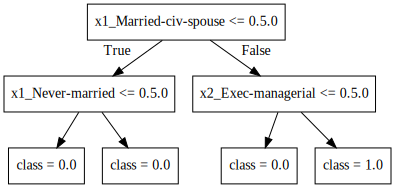

prediction [1.]


Tree 2


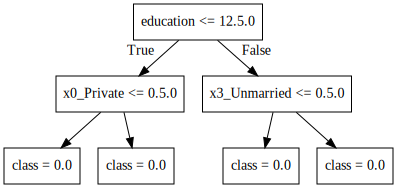

prediction [0.]


Tree 3


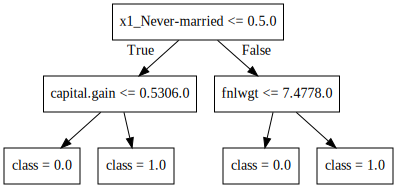

prediction [1.]


In [20]:
for i, tree in enumerate(
    pipe_rf_demo.named_steps["randomforestclassifier"].estimators_
):
    print("\n\nTree", i + 1)
    display(display_tree(feature_names, tree))
    print("prediction", tree.predict(preprocessor.transform(test_example)))

### Some important hyperparameters:

- `n_estimators`: number of decision trees (higher = more complexity)
- `max_depth`: max depth of each decision tree (higher = more complexity)
- `max_features`: the number of features you get to look at each split (higher = more complexity)


### Random forests: number of trees (`n_estimators`) and the fundamental tradeoff 

In [21]:
def make_num_tree_plot(X_train, y_train, X_test, y_test, num_trees):
    """
    Make number of trees vs error rate plot for RandomForestClassifier

    Parameters
    ----------
    model: sklearn classifier model
        The sklearn model
    X_train: numpy.ndarray
        The X part of the train set
    y_train: numpy.ndarray
        The y part of the train set
    X_test: numpy.ndarray
        The X part of the test/validation set
    y_test: numpy.ndarray
        The y part of the test/validation set
    num_trees: int
        The value for `n_estimators` argument of RandomForestClassifier
    Returns
    -------
        None
        Shows the number of trees vs error rate plot

    """
    train_scores = []
    test_scores = []
    for ntree in num_trees:
        model = make_pipeline(preprocessor, RandomForestClassifier(n_estimators=ntree))
        scores = cross_validate(
            model, X_train, y_train, return_train_score=True, scoring=scoring_metric
        )
        train_scores.append(np.mean(scores["train_score"]))
        test_scores.append(np.mean(scores["test_score"]))

    plt.semilogx(num_trees, train_scores, label="train")
    plt.semilogx(num_trees, test_scores, label="cv")
    plt.legend()
    plt.xlabel("number of trees")
    plt.ylabel("scores");

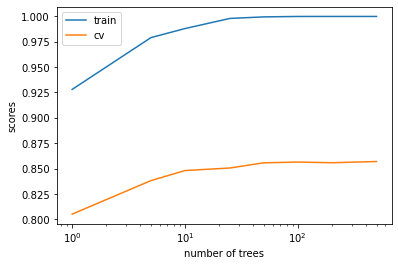

In [22]:
make_num_tree_plot(X_train, y_train, X_test, y_test, (1, 5, 10, 25, 50, 100, 200, 500))

#### Number of trees and fundamental trade-off

- Above: seems like we're beating the fundamental "tradeoff" by increasing training score and not decreasing validation score much.
- This is the promise of ensembles, though it's not guaranteed to work so nicely.

More trees are always better! We pick less trees for speed. 


#### Why does this work? 
- The idea is that if you have many weak learners that only need to perform marginally better than random guessing. 

### Random forests vs decision trees

- Accuracy
    - Random forests are usually more accurate compared to decision trees, in fact they are usually one of the best performing off-the-shelf classifiers. 
    - [The original random forests paper](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf) by Leo Breiman notes that the error rate depends upon the following:  
        - The correlation between any two trees in the forest. Higher the correlation higher the error rate.
        - The error rate of each individual tree in the forest. Lowering the error rate of the individual trees decreases the forest error rate.

- Speed?
    - Slower than decision trees because we are fitting multiple trees 
    - But can easily parallelize training because all trees are independent of each other 
- Overfitting
    - No depth decision tree tends to overfit 
    - Random forests are less likely to overfit
- Interpretability
    - Decision trees are more interpretable 

### 3. Other fancier popular tree-based models 

- Video 3

Three popular and effective tree-based models 

- [XGBoost](https://xgboost.readthedocs.io/en/latest/)
- [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html)
- [CatBoost](https://catboost.ai/docs/concepts/python-quickstart.html)

We'll not go into details. 

### XGBoost 

- Not part of `sklearn` but has similar interface. 
- Install it in your conda environment. 

    ```
    conda install -c conda-forge xgboost
    ```

- Supports missing values
- GPU training
- Networked parallel training
- Supports sparse data
- Typically better scores than random forests    

### LightGBM 

- Not part of `sklearn` but has similar interface. 
- Install it in your conda environment. 
    ```
    conda install -c conda-forge lightgbm
    ```
- Small model size
- Faster
- Typically better scores than random forests    

### CatBoost 

- Not part of `sklearn` but has similar interface. 
- Install it in your conda environment. 
    ```
    conda install -c conda-forge catboost
    ```
- Usually better scores but slower compared to `XGBoost` and `LightGBM`     

In [23]:
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=2000, random_state=123)
)
pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=123))
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=123))
pipe_xgb = make_pipeline(preprocessor, XGBClassifier(random_state=123))
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123))
pipe_catboost = make_pipeline(
    preprocessor, CatBoostClassifier(verbose=0, random_state=123)
)
classifiers = {
    "logistic regression": pipe_lr,
    "decision tree": pipe_dt,
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catboost,
}

In [24]:
dummy = DummyClassifier(strategy="stratified")
results["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [25]:
for (name, model) in classifiers.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )

In [26]:
pd.DataFrame(results)

Dummy      Decision tree     Random forests  \
fit_time     0.007 (+/- 0.000)  0.463 (+/- 0.011)  6.891 (+/- 0.075)   
score_time   0.005 (+/- 0.000)  0.020 (+/- 0.000)  0.096 (+/- 0.002)   
test_score   0.629 (+/- 0.007)  0.813 (+/- 0.003)  0.857 (+/- 0.004)   
train_score  0.634 (+/- 0.004)  1.000 (+/- 0.000)  1.000 (+/- 0.000)   

            logistic regression      decision tree      random forest  \
fit_time      0.736 (+/- 0.036)  0.455 (+/- 0.009)  6.854 (+/- 0.054)   
score_time    0.018 (+/- 0.000)  0.019 (+/- 0.000)  0.094 (+/- 0.001)   
test_score    0.850 (+/- 0.006)  0.813 (+/- 0.003)  0.857 (+/- 0.004)   
train_score   0.851 (+/- 0.001)  1.000 (+/- 0.000)  1.000 (+/- 0.000)   

                       XGBoost           LightGBM            CatBoost  
fit_time     0.476 (+/- 0.024)  0.233 (+/- 0.037)  10.882 (+/- 0.230)  
score_time   0.042 (+/- 0.003)  0.027 (+/- 0.001)   0.024 (+/- 0.001)  
test_score   0.871 (+/- 0.004)  0.871 (+/- 0.004)   0.872 (+/- 0.003)  
train_score  0.908 (+/- 0.001)  0.892 (+/- 0.000)   0.900 (+/- 0.001)

**Some observations**
- Keep in mind all these results are with default hyperparameters
- Ideally we would carry out hyperparameter optimization for all of them and then compare the results. 
- We are using a particular scoring metric (accuracy in this case)
- We are scaling numeric features but it shouldn't matter for these tree-based models. 
- Look at the std. Doesn't look very high. 
    - The scores look more or less stable. 

In [27]:
pd.DataFrame(results)

Dummy      Decision tree     Random forests  \
fit_time     0.007 (+/- 0.000)  0.463 (+/- 0.011)  6.891 (+/- 0.075)   
score_time   0.005 (+/- 0.000)  0.020 (+/- 0.000)  0.096 (+/- 0.002)   
test_score   0.629 (+/- 0.007)  0.813 (+/- 0.003)  0.857 (+/- 0.004)   
train_score  0.634 (+/- 0.004)  1.000 (+/- 0.000)  1.000 (+/- 0.000)   

            logistic regression      decision tree      random forest  \
fit_time      0.736 (+/- 0.036)  0.455 (+/- 0.009)  6.854 (+/- 0.054)   
score_time    0.018 (+/- 0.000)  0.019 (+/- 0.000)  0.094 (+/- 0.001)   
test_score    0.850 (+/- 0.006)  0.813 (+/- 0.003)  0.857 (+/- 0.004)   
train_score   0.851 (+/- 0.001)  1.000 (+/- 0.000)  1.000 (+/- 0.000)   

                       XGBoost           LightGBM            CatBoost  
fit_time     0.476 (+/- 0.024)  0.233 (+/- 0.037)  10.882 (+/- 0.230)  
score_time   0.042 (+/- 0.003)  0.027 (+/- 0.001)   0.024 (+/- 0.001)  
test_score   0.871 (+/- 0.004)  0.871 (+/- 0.004)   0.872 (+/- 0.003)  
train_score  0.908 (+/- 0.001)  0.892 (+/- 0.000)   0.900 (+/- 0.001)

- Decision trees and random forests overfit
    - Other models do not seem to overfit much. 
- Fit times
    - Decision trees are fast but not very accurate
    - LightGBM is faster than decision trees and more accurate! 
    - CatBoost fit time is highest followed by random forests.  
    - There is not much difference between the validation scores of XGBoost, LightGBM, and CatBoost but it is about 48x slower than LightGBM!
    - XGBoost and LightGBM are faster and more accurate than random forest!    
- Scores times  
    - Prediction times are much smaller in all cases. 

### What classifier should I use?

**Simple answer**
- Whichever gets the highest CV score making sure that you're not overusing the validation set.

**Interpretability**
- This is an area of growing interest and concern in ML.
- How important is interpretability for you? 
- In the next class we'll talk about interpretability of non-linear models. 

**Speed/code maintenance**
- Other considerations could be speed (fit and/or predict), maintainability of the code.

Finally, you could use all of them! (Next videos.)

## 4. Averaging 

- Video 4

Earlier we looked at a bunch of classifiers:

In [28]:
classifiers.keys()

dict_keys(['logistic regression', 'decision tree', 'random forest', 'XGBoost', 'LightGBM', 'CatBoost'])

What if we use all these models and let them vote during prediction time? 

In [29]:
from sklearn.ensemble import VotingClassifier

averaging_model = VotingClassifier(
    list(classifiers.items()), voting="soft"
)  # need the list() here for cross_val to work!

This `VotingClassifier` will take a _vote_ using the predictions of the constituent classifier pipelines.

Main parameter: `voting`
- `voting='hard'` 
    - it uses the output of `predict` and actually votes.
- `voting='soft'`
    - with `voting='soft'` it averages the output of `predict_proba` and then thresholds / takes the larger.
- The choice depends on whether you trust `predict_proba` from your base classifiers - if so, it's nice to access that information.

In [30]:
averaging_model.fit(X_train, y_train);

- What happens when you `fit` a `VotingClassifier`?
    - It will fit all constituent models. 
    
Note: it seems sklearn requires us to actually call `fit` on the `VotingClassifier`, instead of passing in pre-fit models. This is an implementation choice rather than a conceptual limitation.

Let's look at particular test examples where `income` is ">50k" (y=1):

In [31]:
test_g50k = (
    test_df.query("income == '>50K'").sample(4, random_state=2).drop(columns=["income"])
)
test_l50k = (
    test_df.query("income == '<=50K'")
    .sample(4, random_state=2)
    .drop(columns=["income"])
)

In [32]:
data = {"Voting classifier": averaging_model.predict(test_g50k)}
pd.DataFrame(data)

Voting classifier
0              >50K
1              >50K
2              >50K
3             <=50K

For hard voting, these are the votes:

In [33]:
r1 = {
    name: classifier.predict(test_g50k)
    for name, classifier in averaging_model.named_estimators_.items()
}
data.update(r1)
pd.DataFrame(data)

Voting classifier  logistic regression  decision tree  random forest  \
0              >50K                    1              1              1   
1              >50K                    1              1              1   
2              >50K                    1              0              1   
3             <=50K                    0              0              0   

   XGBoost  LightGBM  CatBoost  
0        1         1         1  
1        1         1         1  
2        1         1         1  
3        0         0         0

For soft voting, these are the scores:

In [34]:
r1 = {
    name: classifier.predict_proba(test_g50k)
    for name, classifier in averaging_model.named_estimators_.items()
}
r1

{'logistic regression': array([[2.30926389e-14, 1.00000000e+00],
        [4.18799985e-01, 5.81200015e-01],
        [4.96459494e-01, 5.03540506e-01],
        [8.87596360e-01, 1.12403640e-01]]),
 'decision tree': array([[0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.]]),
 'random forest': array([[0.  , 1.  ],
        [0.31, 0.69],
        [0.37, 0.63],
        [0.57, 0.43]]),
 'XGBoost': array([[3.9428473e-04, 9.9960572e-01],
        [2.5976986e-01, 7.4023014e-01],
        [3.1037945e-01, 6.8962055e-01],
        [8.1797528e-01, 1.8202470e-01]], dtype=float32),
 'LightGBM': array([[0.00187645, 0.99812355],
        [0.28722892, 0.71277108],
        [0.28457261, 0.71542739],
        [0.8095596 , 0.1904404 ]]),
 'CatBoost': array([[0.00151693, 0.99848307],
        [0.28344311, 0.71655689],
        [0.32029146, 0.67970854],
        [0.81534647, 0.18465353]])}

(Aside: the probability scores from `DecisionTreeClassifier` are pretty bad)

Let's see how well this model performs.

In [35]:
results["Voting"] = mean_std_cross_val_scores(averaging_model, X_train, y_train)

In [36]:
pd.DataFrame(results)

Dummy      Decision tree     Random forests  \
fit_time     0.007 (+/- 0.000)  0.463 (+/- 0.011)  6.891 (+/- 0.075)   
score_time   0.005 (+/- 0.000)  0.020 (+/- 0.000)  0.096 (+/- 0.002)   
test_score   0.629 (+/- 0.007)  0.813 (+/- 0.003)  0.857 (+/- 0.004)   
train_score  0.634 (+/- 0.004)  1.000 (+/- 0.000)  1.000 (+/- 0.000)   

            logistic regression      decision tree      random forest  \
fit_time      0.736 (+/- 0.036)  0.455 (+/- 0.009)  6.854 (+/- 0.054)   
score_time    0.018 (+/- 0.000)  0.019 (+/- 0.000)  0.094 (+/- 0.001)   
test_score    0.850 (+/- 0.006)  0.813 (+/- 0.003)  0.857 (+/- 0.004)   
train_score   0.851 (+/- 0.001)  1.000 (+/- 0.000)  1.000 (+/- 0.000)   

                       XGBoost           LightGBM            CatBoost  \
fit_time     0.476 (+/- 0.024)  0.233 (+/- 0.037)  10.882 (+/- 0.230)   
score_time   0.042 (+/- 0.003)  0.027 (+/- 0.001)   0.024 (+/- 0.001)   
test_score   0.871 (+/- 0.004)  0.871 (+/- 0.004)   0.872 (+/- 0.003)   
train_score  0.908 (+/- 0.001)  0.892 (+/- 0.000)   0.900 (+/- 0.001)   

                         Voting  
fit_time     19.365 (+/- 0.258)  
score_time    0.190 (+/- 0.005)  
test_score    0.868 (+/- 0.003)  
train_score                 NaN

It appears that here we didn't do much better than our best classifier!

Let's try removing decision tree classifier. 

In [37]:
classifiers_ndt = classifiers.copy()
del classifiers_ndt["decision tree"]
averaging_model_ndt = VotingClassifier(
    list(classifiers_ndt.items()), voting="soft"
)  # need the list() here for cross_val to work!

results["Voting_ndt"] = mean_std_cross_val_scores(
    averaging_model_ndt,
    X_train,
    y_train,
    return_train_score=True,
    scoring=scoring_metric,
)

In [38]:
pd.DataFrame(results)

Dummy      Decision tree     Random forests  \
fit_time     0.007 (+/- 0.000)  0.463 (+/- 0.011)  6.891 (+/- 0.075)   
score_time   0.005 (+/- 0.000)  0.020 (+/- 0.000)  0.096 (+/- 0.002)   
test_score   0.629 (+/- 0.007)  0.813 (+/- 0.003)  0.857 (+/- 0.004)   
train_score  0.634 (+/- 0.004)  1.000 (+/- 0.000)  1.000 (+/- 0.000)   

            logistic regression      decision tree      random forest  \
fit_time      0.736 (+/- 0.036)  0.455 (+/- 0.009)  6.854 (+/- 0.054)   
score_time    0.018 (+/- 0.000)  0.019 (+/- 0.000)  0.094 (+/- 0.001)   
test_score    0.850 (+/- 0.006)  0.813 (+/- 0.003)  0.857 (+/- 0.004)   
train_score   0.851 (+/- 0.001)  1.000 (+/- 0.000)  1.000 (+/- 0.000)   

                       XGBoost           LightGBM            CatBoost  \
fit_time     0.476 (+/- 0.024)  0.233 (+/- 0.037)  10.882 (+/- 0.230)   
score_time   0.042 (+/- 0.003)  0.027 (+/- 0.001)   0.024 (+/- 0.001)   
test_score   0.871 (+/- 0.004)  0.871 (+/- 0.004)   0.872 (+/- 0.003)   
train_score  0.908 (+/- 0.001)  0.892 (+/- 0.000)   0.900 (+/- 0.001)   

                         Voting          Voting_ndt  
fit_time     19.365 (+/- 0.258)  18.691 (+/- 0.400)  
score_time    0.190 (+/- 0.005)   0.171 (+/- 0.003)  
test_score    0.868 (+/- 0.003)   0.871 (+/- 0.004)  
train_score                 NaN   0.921 (+/- 0.001)

Still the results are not better than the best performing model. 

- It didn't happen here but how could the average do better than the best model???
  - From the perspective of the best estimator (in this case CatBoost), why are you adding on worse estimators??


Here's how this can work:

| Example | log reg    | rand forest    | cat boost    | Averaged model |
|--------|--------|--------|---------|---------------|
|  1     | ✅    |   ✅    | ❌     | ✅✅❌=>✅  |
|  2     | ✅    |   ❌    | ✅     | ✅❌✅=>✅  |
|  3     | ❌    |   ✅    | ✅     | ❌✅✅=>✅  |


In short, as long as the different models make different mistakes, this can work.

Why not always do this?

1. `fit`/`predict` time.
2. Reduction in interpretability.
3. Reduction in code maintainability (e.g. Netflix prize).

### What kind of estimators can we combine? 

- You can combine 
    - completely different estimators, or similar estimators.
    - estimators trained on different samples.
    - estimators with different hyperparameter values.

## 5. Stacking 

- Video 5


- Another type of ensemble is stacking.
- Instead of averaging the outputs of each estimator, instead use their outputs as _inputs to another model_.
- By default for classification, it uses logistic regression.
  - We don't need a complex model here necessarily, more of a weighted average.
  - The features going into the logistic regression are the classifier outputs, _not_ the original features!
  - So the number of coefficients = the number of base estimators!

In [39]:
from sklearn.ensemble import StackingClassifier

The code starts to get too slow here; so we'll remove CatBoost. 

In [40]:
classifiers_nocat = classifiers.copy()
del classifiers_nocat["CatBoost"]

In [41]:
stacking_model = StackingClassifier(list(classifiers_nocat.items()))

In [42]:
stacking_model.fit(X_train, y_train);

What's going on in here? 

- It is doing cross-validation by itself by default (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html))
  - It is fitting the base estimators on the training fold
  - And the predicting on the validation fold
  - And then fitting the meta-estimator on that output (on the validation fold)
  
 > Note that estimators_ are fitted on the full X (not sure why it needs to do this) while final_estimator_ is trained using cross-validated predictions of the base estimators using cross_val_predict.

Here is the input features (X) to the meta-model:

In [43]:
valid_sample = train_df.sample(4, random_state=2).drop(columns=["income"])

In [44]:
r3 = {
    name: pipe.predict_proba(valid_sample)
    for (name, pipe) in stacking_model.named_estimators_.items()
}
r3

{'logistic regression': array([[4.33363244e-01, 5.66636756e-01],
        [9.99015113e-01, 9.84886989e-04],
        [8.60862691e-01, 1.39137309e-01],
        [9.95295942e-01, 4.70405800e-03]]),
 'decision tree': array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]]),
 'random forest': array([[0.88, 0.12],
        [1.  , 0.  ],
        [0.95, 0.05],
        [1.  , 0.  ]]),
 'XGBoost': array([[0.7709182 , 0.2290818 ],
        [0.9985829 , 0.00141712],
        [0.92655057, 0.07344944],
        [0.99416995, 0.00583006]], dtype=float32),
 'LightGBM': array([[0.56629894, 0.43370106],
        [0.99263965, 0.00736035],
        [0.91995188, 0.08004812],
        [0.99629847, 0.00370153]])}

- Our meta-model is logistic regression (which it is by default).
- Let's look at the learned coefficients. 

In [45]:
pd.DataFrame(
    data=stacking_model.final_estimator_.coef_[0],
    index=classifiers_nocat.keys(),
    columns=["Coefficient"],
)

Coefficient
logistic regression     0.782704
decision tree          -0.011131
random forest           0.216597
XGBoost                 2.088613
LightGBM                3.602162

- It seems that the LightGBM is being trusted the most. 

In [46]:
stacking_model.predict(test_g50k)

array(['>50K', '>50K', '>50K', '<=50K'], dtype=object)

In [47]:
stacking_model.predict_proba(test_g50k)

array([[0.03381923, 0.96618077],
       [0.19976582, 0.80023418],
       [0.22636102, 0.77363898],
       [0.88812688, 0.11187312]])

(This is the `predict_proba` from logistic regression)

Let's see how well this model performs.

In [48]:
results["Stacking_nocat"] = mean_std_cross_val_scores(
    stacking_model, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [49]:
pd.DataFrame(results)

Dummy      Decision tree     Random forests  \
fit_time     0.007 (+/- 0.000)  0.463 (+/- 0.011)  6.891 (+/- 0.075)   
score_time   0.005 (+/- 0.000)  0.020 (+/- 0.000)  0.096 (+/- 0.002)   
test_score   0.629 (+/- 0.007)  0.813 (+/- 0.003)  0.857 (+/- 0.004)   
train_score  0.634 (+/- 0.004)  1.000 (+/- 0.000)  1.000 (+/- 0.000)   

            logistic regression      decision tree      random forest  \
fit_time      0.736 (+/- 0.036)  0.455 (+/- 0.009)  6.854 (+/- 0.054)   
score_time    0.018 (+/- 0.000)  0.019 (+/- 0.000)  0.094 (+/- 0.001)   
test_score    0.850 (+/- 0.006)  0.813 (+/- 0.003)  0.857 (+/- 0.004)   
train_score   0.851 (+/- 0.001)  1.000 (+/- 0.000)  1.000 (+/- 0.000)   

                       XGBoost           LightGBM            CatBoost  \
fit_time     0.476 (+/- 0.024)  0.233 (+/- 0.037)  10.882 (+/- 0.230)   
score_time   0.042 (+/- 0.003)  0.027 (+/- 0.001)   0.024 (+/- 0.001)   
test_score   0.871 (+/- 0.004)  0.871 (+/- 0.004)   0.872 (+/- 0.003)   
train_score  0.908 (+/- 0.001)  0.892 (+/- 0.000)   0.900 (+/- 0.001)   

                         Voting          Voting_ndt      Stacking_nocat  
fit_time     19.365 (+/- 0.258)  18.691 (+/- 0.400)  42.141 (+/- 0.354)  
score_time    0.190 (+/- 0.005)   0.171 (+/- 0.003)   0.202 (+/- 0.004)  
test_score    0.868 (+/- 0.003)   0.871 (+/- 0.004)   0.872 (+/- 0.003)  
train_score                 NaN   0.921 (+/- 0.001)   0.900 (+/- 0.006)

- The situation here is a bit mind-boggling.
- On each fold of cross-validation it is doing cross-validation.
- This is really loops within loops within loops within loops...

- We can also try a different final estimator:
- Let's `DecisionTreeClassifier` as a final estimator. 

In [50]:
stacking_model_tree = StackingClassifier(
    list(classifiers_nocat.items()), final_estimator=DecisionTreeClassifier(max_depth=3)
)

The results are not very good. But we can look at the tree:

In [51]:
stacking_model_tree.fit(X_train, y_train);

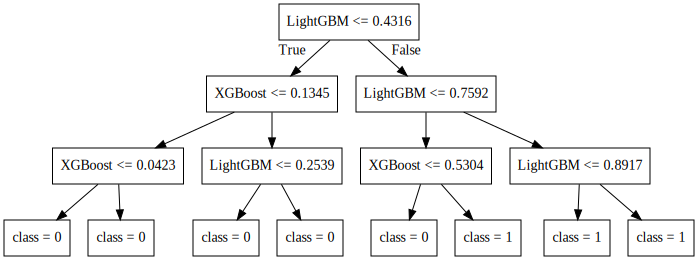

In [52]:
display_tree(list(classifiers_nocat.keys()), stacking_model_tree.final_estimator_)

- What is an advantage of ensembling multiple models as opposed to just choosing one of them?
    - You may get a better score.
- What is an disadvantage of ensembling multiple models as opposed to just choosing one of them?
    - Slower, more code maintenance issues.

#### An effective strategy

- Randomly generate a bunch of models with different hyperparameter configurations, and then stack all the models.

## Summary 

- You have a number of models in your toolbox now.  
- Ensembles are usually pretty effective.
  - Tree-based classifiers are particularly popular and effective on a wide range of problems. 
  - But they trade off code complexity and speed for prediction accuracy.
  - Don't forget that hyperparameter optimization multiplies the slowness of the code!
- Stacking is a bit slower than voting, but generally higher accuracy.
  - As a bonus, you get to see the coefficients for each base classifier.
- All the above models have equivalent regression models.   

#### Relevant papers

- [Fernandez-Delgado et al. 2014](http://jmlr.org/papers/volume15/delgado14a/delgado14a.pdf) compared 179 classifiers on 121 datasets:
    - First best class of methods was Random Forest and second best class of methods was (RBF) SVMs.

- If you like to read original papers [here](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf) is the original paper on Random Forests by Leo Breiman. 

#### (Annotated) True or False questions on Random Forests (Class discussion)

1. Every tree in a random forest uses a different bootstrap sample of the training set. (True)
2. To train a tree in a random forest, we first randomly select a subset of features. The tree is then restricted to only using those features. (False)
3. A reasonable implementation of `predict_proba` for random forests would be for each tree to "vote" and then normalize these vote counts into probabilities. (True)
4. Increasing the hyperparameter max_features (the number of features to consider for a split) makes the model more complex and moves the fundamental tradeoff toward lower training error. (True)
5. A random forest with only one tree is likely to get a higher training error than a decision tree of the same depth. (True)